## Imports

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from khan_helpers import Experiment, Participant
from khan_helpers.constants import FIG_DIR, RAW_DIR
from khan_helpers.functions import multicol_display, show_source

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/mnt/code/khan_helpers/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

## Set plotting params

In [2]:
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('hls')
plt.rcParams['pdf.fonttype'] = 42
color_palette = {
    'c3': sns.color_palette()[1],
    'c2': sns.color_palette()[2],
    'c1': sns.color_palette()[3],
}

## Inspect source for Participant class

In [3]:
show_source(Participant)

## Define plotting function

In [4]:
def bootstrap_ci_plot(
    M, 
    ci=95, 
    n_boots=1000, 
    color='#1f77b4', 
    alpha=0.3, 
    return_bounds=False, 
    label=None, 
    ax=None,
    line_kwargs=None,
    ribbon_kwargs=None
):
    """
    Plots a timeseries of observations with error ribbons denoting the 
    bootstrap confidence interval at each timepoint.  Looks very similar 
    to `seaborn.lineplot`, but runs about 2-3 times as fast.
    
    Parameters
    ----------
    M : numpy.ndarray
        A (timepoints, observations) array of values for plotting
    ci : int, optional
        The size of the confidence interval as a percentage (default: 95).
    n_boots : int, optional
        The number of bootstraps to use for computing the confidence 
        interval. Full-size resamples of observations are constructed 
        (with replacement) for each timepoint independently.
    color : str or tuple of float, optional
        Any color specification accepted by Matplotlib.  See 
        https://matplotlib.org/3.1.1/tutorials/colors/colors.html for a 
        full list of options.  Unless otherwise specified in 
        `ribbon_kwargs`, this also sets the color of the CI ribbon.  
        Defaults to the first color in the currently set palette.
    alpha : float, optional
        Alpha value for the CI ribbon (default: 0.3).
    return_bounds : bool, optional
        If True (default: False), return arrays containing the lower and 
        upper bounds of the computed confidence interval for each 
        timepoint in addition to the axis object.
    label : str, optional
        Label assigned to the line if constructing a legend.
    ax : matplotlib.axes.Axes, optional
        The axes on which to draw the plot.  May be a 
        `matplotlib.axes.Axes` object or one of its various subclasses.  
        Defaults to the current Axes.
    line_kwargs : dict, optional
        Additional keyword arguments forwarded to 
        `matplotlib.axes.Axes.plot`.
    ribbon_kwargs : dict, optional
        Additional keyword argumets forwarded to 
        `matplotlib.axes.Axes.fill_between`.

    Returns
    -------
    returns : matplotlib.axes.Axes or list of objects
        Return value depends on the value passed to `return_bounds`. If 
        False (default), the Axes object alone is returned.  If True, a 
        3-tuple is returned, where the first item is the Axes object and 
        the second and third items are 1-D Numpy arrays respectively 
        containing the lower and upper bounds of the confidence interval 
        at each timepoint.

    """
    line_kwargs = {} if line_kwargs is None else line_kwargs
    ribbon_kwargs = {} if ribbon_kwargs is None else ribbon_kwargs
    if color is None:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    if 'color' not in ribbon_kwargs:
        ribbon_kwargs['color'] = color

    timepoints = np.arange(M.shape[0])
    obs_mean = M.mean(axis=1)
    
    # (n_tpts, n_obs, n_boots) column indices to subsample each row of M
    rand_ixs = np.random.randint(0, M.shape[1], size=(*M.shape, n_boots))
    # (n_tpts, n_boots) subsample means for each timepoint
    boot_means = np.take_along_axis(M[:, np.newaxis], rand_ixs, axis=2).mean(axis=1)
    ci_low = np.percentile(boot_means, (100 - ci) / 2, axis=1)
    ci_high = np.percentile(boot_means, (ci + 100) / 2, axis=1)
    
    if ax is None:
        ax = plt.gca()
    
    ax.fill_between(timepoints, ci_low, ci_high, alpha=alpha, **ribbon_kwargs)
    ax.plot(timepoints, obs_mean, color=color, label=label, **line_kwargs)
    if return_bounds:
        return ax, ci_low, ci_high
    else:
        return ax

## Load data

In [5]:
exp = Experiment()
raw_data = pd.read_csv(RAW_DIR.joinpath('psiturk-data-raw.tsv'), 
                       sep='\t', 
                       index_col='Unnamed: 0')
raw_data.head()

,uniqueid,assignmentid,workerid,hitid,ipaddress,browser,platform,language,cond,counterbalance,codeversion,beginhit,beginexp,endhit,bonus,status,mode,datastring
0,debuga32joxa6zu7q0y:debug3aqf3rz55aocyv9v9oc6r...,3AQF3RZ55AOCYV9V9OC6RCXJB5FF69,A32JOXA6ZU7Q0Y,33K3E8REWX1EFBLACVAPTDY1FXBX8T,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-04-26 17:47:30,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."
1,debuga32joxa6zu7q0y:debug304sm51wa5ar8cvcbztd9...,304SM51WA5AR8CVCBZTD9R2QEXQSBY,A32JOXA6ZU7Q0Y,391FPZIE4DSFRIS8AUT8MJSWOZUHUC,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-04-29 18:43:33,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."
2,debuga32joxa6zu7q0y:debug3aqf3rz55aocyv9v9oc6r...,3AQF3RZ55AOCYV9V9OC6RCXJB6M6F9,A32JOXA6ZU7Q0Y,31MBOZ6PAPXLRKUYFON6K5ZXYGXCL5,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-04-29 19:29:40,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."
3,debugdebugwzop7d:debugdebug4j19zm,3OE22WJIGKUURVP5JML3JHFDLUOUQ4,A32JOXA6ZU7Q0Y,3P520RYKCIC3BP8D9SSZXMP6JRR5U9,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-05-01 19:34:15,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."
4,debuga32joxa6zu7q0y:debug3dzqrbdbsnlm5hrzw6e7r...,3DZQRBDBSNLM5HRZW6E7R84EQ50S3U,A32JOXA6ZU7Q0Y,36FFXPMSTAUKED8BE8HZND076EHHOC,172.20.0.5,safari,macos,UNKNOWN,0,0,1.0,2019-05-03 17:54:55,NaN,NaN,0,1,sandbox,"{'condition': 0, 'counterbalance': 0, 'assignm..."


## Create Participant objects

In [6]:
participants = []
for ix, row in tqdm(raw_data.iterrows(), total=raw_data.shape[0], leave=False):
    p = Participant.from_psiturk(row, subid=f'P{ix + 1}')
    participants.append(p)

  0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
# 6 sample participants' data for first 5 questions of quiz block 1
multicol_display(*(p.head() for p in participants[:6]), 
                 ncols=3, 
                 table_css={'border-collapse': 'separate', 
                            'border-spacing': '0 1em'},
                 row_css={'background-color': 'white'})

,qID,accuracy,response,qset,lecture
0,13,1,A,0,1
1,21,0,B,0,2
2,12,0,D,0,1
3,16,1,A,0,2
4,28,1,A,0,2
,qID,accuracy,response,qset,lecture
0,24,0,B,0,2
1,25,0,B,0,2
2,2,0,D,0,1
3,30,0,B,0,2


## Reconstruct memory traces for each set of quiz questions, for each lecture

In [8]:
# Participant object to store across-participant avgerages
avg_participant = Participant('avg')

traces = {}
for lecture in ('forces', 'bos'):
    lecture_traj = exp.get_lecture_traj(lecture)
    trace_arr = np.empty((3, 50, lecture_traj.shape[0]), dtype=np.float64)
    for qset in range(3):
        store_key = f'{lecture}_qset{qset}'
        # reconstruct trace for each lecture, for each question set
        for i, p in enumerate(participants):
            # store trace in participant data object
            trace_arr[qset, i] = p.reconstruct_trace(exp, 
                                                     lecture=lecture, 
                                                     qset=qset, 
                                                     store=store_key)
        # store average in avg participant object
        avg_participant.store_trace(trace_arr[qset].mean(axis=0), store_key)
    traces[lecture] = trace_arr

## Save Participant objects with reconstructed traces

In [9]:
# for p in participants:
#     p.save()
    
# avg_participant.save()

## Plot model-derived content mastery

In [10]:
ff_traces = np.swapaxes(traces['forces'], 1, 2)
bos_traces = np.swapaxes(traces['bos'], 1, 2)

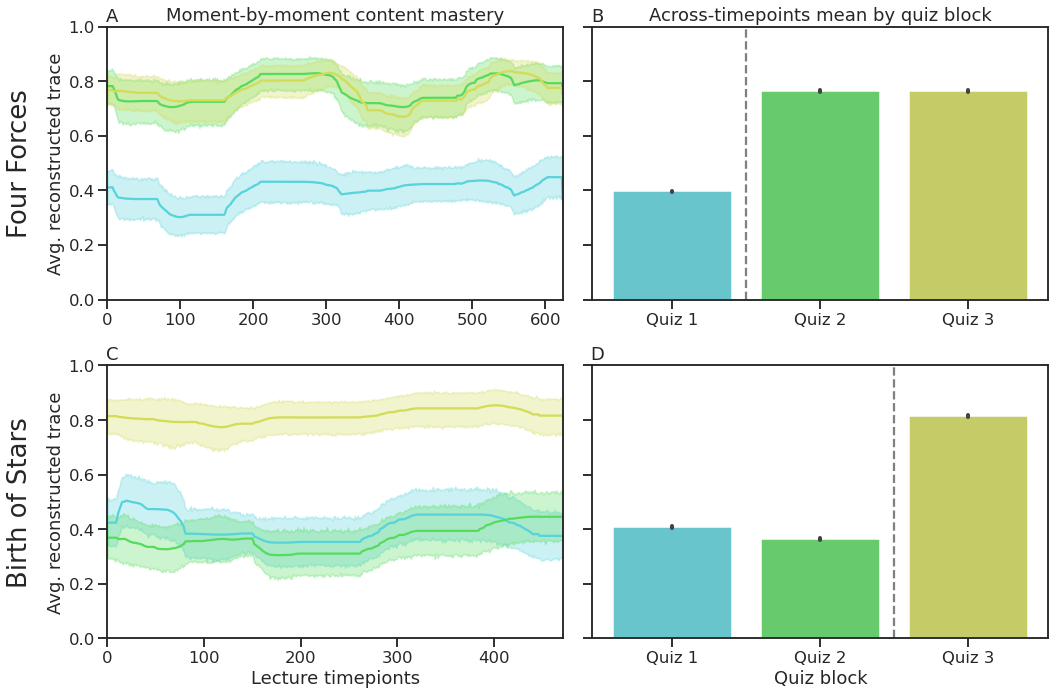

In [11]:
# NOTE: figure takes ~2 minutes to generate
fig, axarr = plt.subplots(2, 2, sharey=True)
fig.set_size_inches(15, 10)
((a, b),
 (c, d)) = axarr

for quiz in range(3):
    bootstrap_ci_plot(ff_traces[quiz], 
                     color=color_palette[f'c{quiz+1}'], 
                     ax=a)

a.set_ylim(0, 1)
a.set_xlim(0, ff_traces[0].shape[0])
a.set_ylabel('Avg. reconstructed trace')
a.set_title('Moment-by-moment content mastery')
a.annotate('Four Forces', xy=(-.75, .5), xycoords=a.yaxis.label, 
           size='x-large', rotation=90, ha='right', va='center')

sns.barplot(data=np.split(ff_traces, 3), 
            palette=[color_palette[f'c{i}'] for i in range(1, 4)], 
            ax=b)
b.set_xticklabels(['Quiz 1', 'Quiz 2', 'Quiz 3'])
b.vlines(x=.5, ymin=0, ymax=1, linestyles='dashed', colors='gray')
b.set_ylim(0, 1)
b.set_title('Across-timepoints mean by quiz block')

for quiz in range(3):
    bootstrap_ci_plot(bos_traces[quiz], 
                     color=color_palette[f'c{quiz+1}'], 
                     ax=c)

c.set_ylim(0, 1)
c.set_xlim(0, bos_traces[0].shape[0])
c.set_xlabel('Lecture timepionts')
c.set_ylabel('Avg. reconstructed trace')
c.annotate('Birth of Stars', xy=(-.75, .5), xycoords=c.yaxis.label, 
           size='x-large', rotation=90, ha='right', va='center')

sns.barplot(data=np.split(bos_traces, 3), 
            palette=[color_palette[f'c{i}'] for i in range(1, 4)], 
            ax=d)
d.set_xticklabels(['Quiz 1', 'Quiz 2', 'Quiz 3'])
d.vlines(x=1.5, ymin=0, ymax=1, linestyles='dashed', colors='gray')
d.set_ylim(0, 1)
d.set_xlabel('Quiz block')

labels = 'ABCD'
for i, ax in enumerate((a, b, c, d)):
    ax.text(0.01, 1.02, labels[i], horizontalalignment='center', 
            transform=ax.transAxes, fontsize=18)

plt.tight_layout()
# plt.savefig(FIG_DIR.joinpath('content-mastery.pdf'), bbox_inches='tight')
plt.show()